In [1]:
%load_ext autoreload
%autoreload 2

import sys
import copy
import math
import pickle

sys.path.append("../../")

import numpy as np
import torch
import matplotlib.pyplot as plt

import implicitmodules.torch as dm

#torch.set_num_threads(6)
torch.set_default_tensor_type(torch.FloatTensor)

* Make source

In [2]:
epsilon = .5
a = 10.
b = 1.
d = 1.
c = 41.
c0 = 40.
shape_rigid0 = torch.tensor([[0., 0.], [c0, 0.], [c0, a], [0., a], [0., 0.]])
shape_growth0 = torch .tensor([[0., a], [c0, a], [c0, a + b], [0., a + b], [0., a]])

shape_rigid = torch.tensor([[-epsilon, -epsilon], [c + epsilon, -epsilon], [c + epsilon, a +epsilon], [- epsilon, a + epsilon], [-epsilon, -epsilon]])
shape_growth = torch .tensor([[-epsilon, a-epsilon + d], [c+epsilon, a-epsilon + d], [c+epsilon, a + b+epsilon + d], [-epsilon, a + b+epsilon + d], [-epsilon, a-epsilon + d]])


In [3]:
Nh = 40
Nvr = 10
Nvg = 2
Xr0 = torch.stack([torch.linspace(0., c0, Nh), torch.zeros([Nh])]).t()
Xr1 = torch.stack([torch.linspace(c0, 0., Nh), torch.zeros([Nh]) + a]).t()
Yr0 = torch.stack([torch.zeros([Nvr]) + c0, torch.linspace(0., a, Nvr)]).t()
Yr1 = torch.stack([torch.zeros([Nvr]), torch.linspace(a, 0., Nvr)]).t()

Xg0 = torch.stack([torch.linspace(0., c0, Nh), torch.zeros([Nh]) + a]).t()
Xg1 = torch.stack([torch.linspace(c0, 0., Nh), torch.zeros([Nh]) + a + b]).t()
Yg0 = torch.stack([torch.zeros([Nvr]) + c0, torch.linspace(a, a + b, Nvr)]).t()
Yg1 = torch.stack([torch.zeros([Nvr]), torch.linspace(a + b, a, Nvr)]).t()

shape_rigid0 = torch.cat([Xr0, Yr0, Xr1, Yr1], dim=0)
shape_growth0 = torch.cat([Xg0, Yg0, Xg1, Yg1], dim=0)

(-2.6, 43.6, -1.15, 13.15)

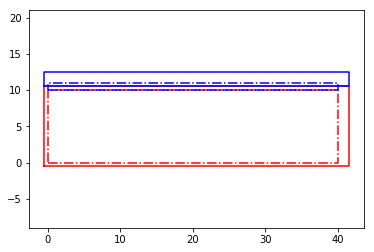

In [4]:
plt.figure()
plt.plot(shape_rigid[:,0], shape_rigid[:,1 ], '-r')
plt.plot(shape_rigid0[:,0], shape_rigid0[:,1 ], '-.r')
plt.plot(shape_growth[:,0], shape_growth[:,1 ], '-b')
plt.plot(shape_growth0[:,0], shape_growth0[:,1 ], '-.b')
plt.axis('equal')

In [5]:
aabb_rigid = dm.Utilities.AABB.build_from_points(shape_rigid)
aabb_growth = dm.Utilities.AABB.build_from_points(shape_growth)

In [6]:
density_rigid = 0.5
density_growth = 0.5

pts_rigid = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_rigid, density_rigid, shape=shape_rigid, side=1)
print(pts_rigid.shape)
pts_growth = dm.Utilities.fill_area_uniform_density(dm.Utilities.area_shape, aabb_growth, density_growth, shape=shape_growth, side=1)
print(pts_growth.shape)

torch.Size([240, 2])
torch.Size([60, 2])


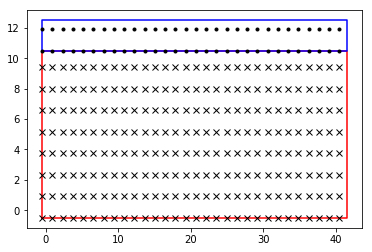

In [7]:
plt.figure()
plt.plot(shape_rigid[:,0], shape_rigid[:,1 ], '-r')
plt.plot(shape_growth[:,0], shape_growth[:,1 ], '-b')
plt.plot(pts_rigid[:,0], pts_rigid[:,1], 'xk')
plt.plot(pts_growth[:,0], pts_growth[:,1], '.k')

(-2.550609588623047,
 42.562801361083984,
 -1.1207106590270997,
 12.534923839569093)

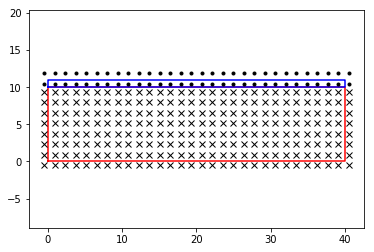

In [8]:
#%matplotlib qt5
plt.figure()
plt.plot(shape_rigid0[:,0], shape_rigid0[:,1 ], '-r')
plt.plot(shape_growth0[:,0], shape_growth0[:,1 ], '-b')
plt.plot(pts_rigid[:,0], pts_rigid[:,1], 'xk')
plt.plot(pts_growth[:,0], pts_growth[:,1], '.k')
plt.axis('equal')

(-2.550609588623047,
 42.562801361083984,
 -1.1207106590270997,
 12.534923839569093)

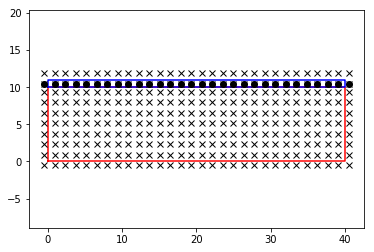

In [9]:
N_rigid = pts_rigid.shape[0]
N_growth = pts_growth.shape[0]
pts_implicit1 = torch.cat([pts_rigid, pts_growth], dim=0)
plt.figure()
plt.plot(shape_rigid0[:,0], shape_rigid0[:,1 ], '-r')
plt.plot(shape_growth0[:,0], shape_growth0[:,1 ], '-b')
plt.plot(pts_implicit1[:,0], pts_implicit1[:,1], 'xk')
#plt.plot(pts_implicit1[:N_rigid,0], pts_implicit1[:N_rigid,1], 'ok')
plt.plot(pts_implicit1[N_rigid::2,0], pts_implicit1[N_rigid::2,1], 'ok')
plt.axis('equal')

* Define C

In [10]:
import math

Npers = [1.,3]
#Npers = [0., 1, 2, 3, 4, 5]
dimC = len(Npers)
C = torch.zeros(pts_implicit1.shape[0], 2, len(Npers))

for i in range(len(Npers)):
    Nper = Npers[i]
    theta = Nper * torch.linspace(0, 2 * math.pi, int(0.5 * N_growth))
    C[N_rigid::2, 0, i] = torch.tensor([math.cos(thetai) for thetai in theta])
    C[N_rigid+1::2, 0, i] = torch.tensor([math.cos(thetai) for thetai in theta])

In [11]:
C.shape

torch.Size([300, 2, 2])

In [12]:
%matplotlib qt5
ax_left = plt.subplot(1, 1, 1)
plt.plot(shape_rigid0[:,0], shape_rigid0[:,1 ], '-r')
plt.plot(shape_growth0[:,0], shape_growth0[:,1 ], '-b')
plt.plot(pts_implicit1[:,0], pts_implicit1[:,1], 'xk')
#plt.plot(pts_implicit1[:N_rigid,0], pts_implicit1[:N_rigid,1], 'ok')
dm.Utilities.plot_C_ellipse(ax_left, pts_implicit1, C, c_index=0, scale=0.5, color='red')
plt.axis('equal')

(-2.550609588623047,
 42.562801361083984,
 -1.1207106590270997,
 12.534923839569093)

In [13]:
angles = 0. * math.pi * torch.ones(pts_implicit1.shape[0])
R = torch.stack([dm.Utilities.rot2d(a) for a in angles])

In [14]:
cotan_pts = torch.zeros_like(pts_implicit1)
mm = 2000.
cotan_pts[-1, 0] = mm
#cotan_pts[-1, 1] = mm

cotan_pts[N_rigid + 25, 1] = mm
cotan_pts[N_rigid + 35, 1] = mm
cotan_pts[N_rigid + 30, 1] = -2*mm

cotan_pts[N_rigid + 1, 0] = -mm
#cotan_pts[N_rigid + 1, 1] = mm
#cotan_pts = 200 * (torch.rand_like(pts_implicit1) - 0.7)
cotan_R = torch.zeros_like(R)

Define implicit module

In [15]:
sigma1 = 3.
nu = 0.001
implicit1 = dm.DeformationModules.create_deformation_module('implicit_order_1', dim=2, nb_pts=pts_implicit1.shape[0], C=C, sigma=sigma1, nu=nu, coeff=1., gd=(pts_implicit1.view(-1).requires_grad_(), R.view(-1).requires_grad_()), cotan = (cotan_pts.view(-1).requires_grad_(), cotan_R.view(-1).requires_grad_()))

Define silent modules and shoot

In [16]:
#silent_imp = dm.DeformationModules.create_deformation_module('silent_points', dim=2, nb_pts=pts_implicit1.shape[0], gd=pts_implicit1.view(-1).requires_grad_())
silent_rigid = dm.DeformationModules.create_deformation_module('silent_points', dim=2, nb_pts=shape_rigid0.shape[0], gd=shape_rigid0.view(-1).requires_grad_())
silent_growth = dm.DeformationModules.create_deformation_module('silent_points', dim=2, nb_pts=shape_growth0.shape[0], gd=shape_growth0.view(-1).requires_grad_())

In [17]:
intermediate_states, intermediate_controls = dm.HamiltonianDynamic.shoot(dm.HamiltonianDynamic.Hamiltonian([implicit1, silent_rigid, silent_growth]), 10, 'euler', intermediates=True)
pts = implicit1.manifold.gd[0].detach().view(-1, 2)
pts_rigid = silent_rigid.manifold.gd.detach().view(-1, 2)
pts_growth = silent_growth.manifold.gd.detach().view(-1, 2)

step  10


(-5.502126955986023, 45.51434209346771, -3.4236892819404603, 15.51946941614151)

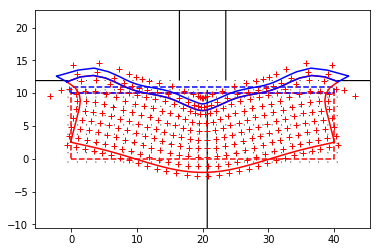

In [18]:
%matplotlib inline
ax_left = plt.subplot(1, 1, 1)
plt.plot(shape_rigid0[:,0], shape_rigid0[:,1 ], '--r')
plt.plot(shape_growth0[:,0], shape_growth0[:,1 ], '--b')
#plt.plot(pts_implicit1[:,0], pts_implicit1[:,1], '.k')
plt.plot(pts_rigid[:,0], pts_rigid[:,1], '-r')
plt.plot(pts_growth[:,0], pts_growth[:,1], '-b')
plt.quiver(pts_implicit1[:,0], pts_implicit1[:,1], cotan_pts[:,0], cotan_pts[:,1])
plt.plot(pts[:,0], pts[:,1], '+r')
#plt.plot(pts_imp[:,0], pts_imp[:,1], 'xk')
plt.axis('equal')

(-5.502126955986023, 45.51434209346771, -3.4236892819404603, 15.51946941614151)

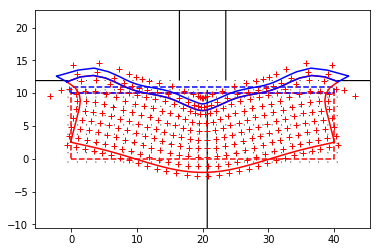

In [19]:
%matplotlib inline
ax_left = plt.subplot(1, 1, 1)
plt.plot(shape_rigid0[:,0], shape_rigid0[:,1 ], '--r')
plt.plot(shape_growth0[:,0], shape_growth0[:,1 ], '--b')
#plt.plot(pts_implicit1[:,0], pts_implicit1[:,1], '.k')
plt.plot(pts_rigid[:,0], pts_rigid[:,1], '-r')
plt.plot(pts_growth[:,0], pts_growth[:,1], '-b')
plt.quiver(pts_implicit1[:,0], pts_implicit1[:,1], cotan_pts[:,0], cotan_pts[:,1])
plt.plot(pts[:,0], pts[:,1], '+r')
#plt.plot(pts_imp[:,0], pts_imp[:,1], 'xk')
plt.axis('equal')

In [20]:
print(intermediate_controls)

[[tensor([1.0095, 1.0466]), tensor([]), tensor([])], [tensor([0.9916, 0.9838]), tensor([]), tensor([])], [tensor([0.9887, 0.9282]), tensor([]), tensor([])], [tensor([0.9992, 0.8771]), tensor([]), tensor([])], [tensor([1.0167, 0.8164]), tensor([]), tensor([])], [tensor([1.0357, 0.7360]), tensor([]), tensor([])], [tensor([1.0910, 0.6777]), tensor([]), tensor([])], [tensor([1.2082, 0.6494]), tensor([]), tensor([])], [tensor([1.3811, 0.5965]), tensor([]), tensor([])], [tensor([1.4683, 0.3734]), tensor([]), tensor([])]]


Shoot again with some controls shutdown

In [156]:
cont = [] 
keep_cont = [False, True]#, False, False, True]

for i in range(10):
    cont_i = []
    for j in range(len(keep_cont)):
        if keep_cont[j]:
            cont_i.append(intermediate_controls[i][0][j].clone())
        else:
                cont_i.append(torch.zeros_like(intermediate_controls[i][0][j].clone()))
    cont.append([torch.tensor(cont_i), torch.tensor([]), torch.tensor([])])

In [157]:
implicit1_rg = dm.DeformationModules.create_deformation_module('implicit_order_1', dim=2, nb_pts=pts_implicit1.shape[0], C=C, sigma=sigma1, nu=nu, coeff=1., gd=(pts_implicit1.view(-1).requires_grad_(), R.view(-1).requires_grad_()), cotan = (cotan_pts.view(-1).requires_grad_(), cotan_R.view(-1).requires_grad_()))
silent_rigid_rg = dm.DeformationModules.create_deformation_module('silent_points', dim=2, nb_pts=shape_rigid0.shape[0], gd=shape_rigid0.view(-1).requires_grad_())
silent_growth_rg = dm.DeformationModules.create_deformation_module('silent_points', dim=2, nb_pts=shape_growth0.shape[0], gd=shape_growth0.view(-1).requires_grad_())

In [158]:
print(cont)

[[tensor([0.0000, 1.0466]), tensor([]), tensor([])], [tensor([0.0000, 0.9838]), tensor([]), tensor([])], [tensor([0.0000, 0.9282]), tensor([]), tensor([])], [tensor([0.0000, 0.8771]), tensor([]), tensor([])], [tensor([0.0000, 0.8164]), tensor([]), tensor([])], [tensor([0.0000, 0.7360]), tensor([]), tensor([])], [tensor([0.0000, 0.6777]), tensor([]), tensor([])], [tensor([0.0000, 0.6494]), tensor([]), tensor([])], [tensor([0.0000, 0.5965]), tensor([]), tensor([])], [tensor([0.0000, 0.3734]), tensor([]), tensor([])]]


In [159]:
intermediate_states_rg, intermediate_controls_rg = dm.HamiltonianDynamic.shoot(dm.HamiltonianDynamic.Hamiltonian([implicit1_rg, silent_rigid_rg, silent_growth_rg]), 10, 'euler', controls= cont, intermediates=True)
pts_rg = implicit1_rg.manifold.gd[0].detach().view(-1, 2)
pts_rigid_rg = silent_rigid_rg.manifold.gd.detach().view(-1, 2)
pts_growth_rg = silent_growth_rg.manifold.gd.detach().view(-1, 2)

step  10


(-4.491698741912842,
 44.489686489105225,
 -2.866050100326538,
 14.608517026901245)

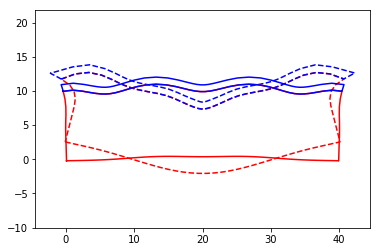

In [160]:
%matplotlib qt5
ax_left = plt.subplot(1, 1, 1)
#plt.plot(shape_rigid0[:,0], shape_rigid0[:,1 ], '--r')
#plt.plot(shape_growth0[:,0], shape_growth0[:,1 ], '--b')
#plt.plot(pts_implicit1[:,0], pts_implicit1[:,1], '.k')
plt.plot(pts_rigid[:,0], pts_rigid[:,1], '--r')
plt.plot(pts_growth[:,0], pts_growth[:,1], '--b')
#plt.plot(pts[:,0], pts[:,1], '.r')

plt.plot(pts_rigid_rg[:,0], pts_rigid_rg[:,1], '-r')
plt.plot(pts_growth_rg[:,0], pts_growth_rg[:,1], '-b')
#plt.plot(pts_rg[:,0], pts_rg[:,1], 'xr')
#plt.plot(pts_imp[:,0], pts_imp[:,1], 'xk')
plt.axis('equal')

Plot growth ratio ( C . control)

In [40]:
t = 0
h = intermediate_controls[t][0]
C_t = torch.tensordot(C, h, dims=1).view(-1, 2, 1)

X = intermediate_states[t].gd[0][0].view(-1,2)

In [21]:
%matplotlib qt5
ax_left = plt.subplot(1, 1, 1)
#plt.plot(shape_rigid0[:,0], shape_rigid0[:,1 ], '-r')
#plt.plot(shape_growth0[:,0], shape_growth0[:,1 ], '-b')
plt.plot(X[:,0], X[:,1], 'xk')
#plt.plot(pts_implicit1[:N_rigid,0], pts_implicit1[:N_rigid,1], 'ok')
dm.Utilities.plot_C_ellipse(ax_left, X, C_t, c_index=0, scale=1., color='red')
plt.axis('equal')

(-2.550609588623047,
 42.562801361083984,
 -1.1207106590270997,
 12.534923839569093)

Define target

In [21]:
# Source/target : implicit points
target_noisefree = implicit1.manifold.gd[0].detach().view(-1, 2)
source_pts = pts_implicit1.clone()
target_pts = target_noisefree #+ 0.2*torch.rand(*target_noisefree.shape)

In [23]:
# Source/target : surrounding shape
target_noisefree = torch.cat([pts_rigid.clone(), pts_growth.clone()], dim=0)
source_pts = torch.cat([shape_rigid0.clone(), shape_growth0.clone()], dim=0)
target_pts = target_noisefree + 0.2*torch.rand(*target_noisefree.shape)

In [21]:
target_noisefree.shape

torch.Size([300, 2])

In [22]:
%matplotlib qt5
ax_left = plt.subplot(1, 1, 1)
#plt.plot(pts_implicit1[:,0], pts_implicit1[:,1], '.k')
plt.plot(target_noisefree[:,0], target_noisefree[:,1], '.r')
plt.plot(target_pts[:,0], target_pts[:,1], '+r')
plt.axis('equal')

(-4.8469722986221315,
 44.859150242805484,
 -5.066342496871949,
 16.96825804710388)

Define C for optimisation (can be different from the one used to generate the target)

In [22]:
Npers_opt = [0., 1, 2, 3, 4, 5, 6]
dimC_opt = len(Npers)
C_opt = torch.zeros(pts_implicit1.shape[0], 2, len(Npers_opt))

for i in range(len(Npers_opt)):
    Nper = Npers_opt[i]
    theta = Nper * torch.linspace(0, 2 * math.pi, int(0.5 * N_growth))
    C_opt[N_rigid::2, 0, i] = torch.tensor([math.cos(thetai) for thetai in theta])
    C_opt[N_rigid+1::2, 0, i] = torch.tensor([math.cos(thetai) for thetai in theta])

Define implicit module and model

In [23]:
implicit1_opt = dm.DeformationModules.create_deformation_module('implicit_order_1', dim=2, nb_pts=pts_implicit1.shape[0], C=C_opt, sigma=sigma1, nu=nu, coeff=1., gd=(pts_implicit1.view(-1).requires_grad_(), R.view(-1).requires_grad_()))

In [24]:
#implicit0_opt = dm.DeformationModules.create_deformation_module('implicit_order_0', dim=2, nb_pts=pts_implicit1.shape[0], sigma=sigma1, nu=nu, coeff=10., gd=pts_implicit1.clone().view(-1).requires_grad_())

In [25]:
#model = dm.Models.ModelPointsRegistration([source_pts], [implicit1_opt], [dm.Attachment.EuclideanPointwiseDistanceAttachment(weight=1.)], lam=100.)
model = dm.Models.ModelPointsRegistrationOnlyAttachment([source_pts], [implicit1_opt], [dm.Attachment.EuclideanPointwiseDistanceAttachment(weight=1.)], lam=100.)

In [26]:
fitter = dm.Models.ModelFittingScipy(model, 1.)

Fitting

In [27]:
costs = fitter.fit([target_pts], 30, log_interval=1)

step  10
only attachment
Initial energy = 59223.750
step  10
only attachment
step  10
only attachment
step  10
only attachment
step  10
only attachment
Iteration: 1 
Total energy = 39090.191406 
Attach cost = 39090.191406 
Deformation cost = 240.076447
step  10
only attachment
step  10
only attachment
Iteration: 2 
Total energy = 27994.291016 
Attach cost = 27994.291016 
Deformation cost = 836.834106
step  10
only attachment
Iteration: 3 
Total energy = 27755.429688 
Attach cost = 27755.429688 
Deformation cost = 1185.799072
step  10
only attachment
Iteration: 4 
Total energy = 27069.583984 
Attach cost = 27069.583984 
Deformation cost = 1027.780029
step  10
only attachment
Iteration: 5 
Total energy = 26607.410156 
Attach cost = 26607.410156 
Deformation cost = 943.312256
step  10
only attachment
Iteration: 6 
Total energy = 25299.271484 
Attach cost = 25299.271484 
Deformation cost = 879.539307
step  10
only attachment
Iteration: 7 
Total energy = 20617.316406 
Attach cost = 20617.31

Shoot with estimated parameters

In [28]:
compound = dm.DeformationModules.CompoundModule(model.modules)
compound.manifold.fill(model.init_manifold)

In [29]:
compound.module_list

In [30]:
intermediate_states_opt, intermediate_controls_opt = dm.HamiltonianDynamic.shoot(dm.HamiltonianDynamic.Hamiltonian(compound), 10, 'euler', intermediates=True)

step  10


In [31]:
pts = compound.manifold.gd[0].detach().view(-1, 2)

Plot result

(-5.502126955986023,
 45.51434209346771,
 -3.4317103385925294,
 15.621092891693115)

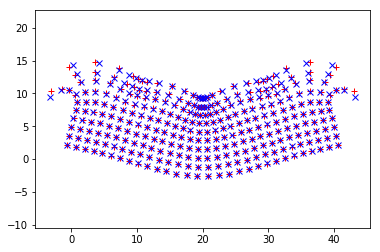

In [32]:
%matplotlib qt5
ax_left = plt.subplot(1, 1, 1)
#plt.plot(shape_rigid0[:,0], shape_rigid0[:,1 ], '--r')
#plt.plot(shape_growth0[:,0], shape_growth0[:,1 ], '--b')
#plt.plot(pts_implicit1[:,0], pts_implicit1[:,1], '.k')
#plt.plot(pts_rigid[:,0], pts_rigid[:,1], '-r')
#plt.plot(pts_growth[:,0], pts_growth[:,1], '-b')
#plt.quiver(pts_implicit1[:,0], pts_implicit1[:,1], cotan_pts[:,0], cotan_pts[:,1])
plt.plot(pts[:,0], pts[:,1], '+r')
#plt.plot(target_pts[:,0], target_pts[:,1], 'xk')
plt.plot(target_noisefree[:,0], target_noisefree[:,1], 'xb')


plt.axis('equal')

Compare controls

In [33]:
print(intermediate_controls_opt)

[[tensor([]), tensor([ 0.1278,  1.1015,  0.1393,  0.8595, -0.1151, -0.2318, -0.1536])], [tensor([]), tensor([ 0.0797,  1.0724,  0.0933,  0.8430, -0.1232, -0.2407, -0.1546])], [tensor([]), tensor([ 0.0353,  1.0537,  0.0534,  0.8274, -0.1243, -0.2477, -0.1450])], [tensor([]), tensor([-0.0047,  1.0440,  0.0217,  0.8078, -0.1199, -0.2612, -0.1195])], [tensor([]), tensor([-4.0197e-02,  1.0397e+00, -2.5967e-04,  7.8201e-01, -1.1129e-01,
        -2.8697e-01, -8.8882e-02])], [tensor([]), tensor([-0.0728,  1.0344, -0.0143,  0.7477, -0.1004, -0.3239, -0.0692])], [tensor([]), tensor([-0.1038,  1.0256, -0.0210,  0.7033, -0.0884, -0.3702, -0.0701])], [tensor([]), tensor([-0.1335,  1.0141, -0.0192,  0.6504, -0.0759, -0.4231, -0.0936])], [tensor([]), tensor([-0.1612,  1.0009, -0.0105,  0.5912, -0.0654, -0.4776, -0.1370])], [tensor([]), tensor([-0.1857,  0.9862,  0.0011,  0.5249, -0.0645, -0.5324, -0.1974])]]


In [35]:
print(intermediate_controls)

[[tensor([1.0095, 1.0466]), tensor([]), tensor([])], [tensor([0.9916, 0.9838]), tensor([]), tensor([])], [tensor([0.9887, 0.9282]), tensor([]), tensor([])], [tensor([0.9992, 0.8771]), tensor([]), tensor([])], [tensor([1.0167, 0.8164]), tensor([]), tensor([])], [tensor([1.0357, 0.7360]), tensor([]), tensor([])], [tensor([1.0910, 0.6777]), tensor([]), tensor([])], [tensor([1.2082, 0.6494]), tensor([]), tensor([])], [tensor([1.3811, 0.5965]), tensor([]), tensor([])], [tensor([1.4683, 0.3734]), tensor([]), tensor([])]]


Re-shoot with controls that 'are supposed to be zero' shutdown

In [41]:
cont = [] 
keep_cont = [False, True, False, True, False, False, False]

for i in range(10):
    cont_i = []
    for j in range(len(keep_cont)):
        if keep_cont[j]:
            cont_i.append(intermediate_controls_opt[i][1][j].clone())
        else:
                cont_i.append(torch.zeros_like(intermediate_controls_opt[i][1][j].clone()))
    cont.append([torch.tensor(cont_i), torch.tensor([]), torch.tensor([])])

In [42]:
C_opt.shape

torch.Size([300, 2, 7])

In [43]:
implicit1_rg = dm.DeformationModules.create_deformation_module('implicit_order_1', dim=2, nb_pts=pts_implicit1.shape[0], C=C_opt, sigma=sigma1, nu=nu, coeff=1., gd=(pts_implicit1.view(-1).requires_grad_(), R.view(-1).requires_grad_()), cotan = (cotan_pts.view(-1).requires_grad_(), cotan_R.view(-1).requires_grad_()))
silent_rigid_rg = dm.DeformationModules.create_deformation_module('silent_points', dim=2, nb_pts=shape_rigid0.shape[0], gd=shape_rigid0.view(-1).requires_grad_())
silent_growth_rg = dm.DeformationModules.create_deformation_module('silent_points', dim=2, nb_pts=shape_growth0.shape[0], gd=shape_growth0.view(-1).requires_grad_())

In [44]:
print(cont)

[[tensor([0.0000, 1.1015, 0.0000, 0.8595, 0.0000, 0.0000, 0.0000]), tensor([]), tensor([])], [tensor([0.0000, 1.0724, 0.0000, 0.8430, 0.0000, 0.0000, 0.0000]), tensor([]), tensor([])], [tensor([0.0000, 1.0537, 0.0000, 0.8274, 0.0000, 0.0000, 0.0000]), tensor([]), tensor([])], [tensor([0.0000, 1.0440, 0.0000, 0.8078, 0.0000, 0.0000, 0.0000]), tensor([]), tensor([])], [tensor([0.0000, 1.0397, 0.0000, 0.7820, 0.0000, 0.0000, 0.0000]), tensor([]), tensor([])], [tensor([0.0000, 1.0344, 0.0000, 0.7477, 0.0000, 0.0000, 0.0000]), tensor([]), tensor([])], [tensor([0.0000, 1.0256, 0.0000, 0.7033, 0.0000, 0.0000, 0.0000]), tensor([]), tensor([])], [tensor([0.0000, 1.0141, 0.0000, 0.6504, 0.0000, 0.0000, 0.0000]), tensor([]), tensor([])], [tensor([0.0000, 1.0009, 0.0000, 0.5912, 0.0000, 0.0000, 0.0000]), tensor([]), tensor([])], [tensor([0.0000, 0.9862, 0.0000, 0.5249, 0.0000, 0.0000, 0.0000]), tensor([]), tensor([])]]


In [45]:
intermediate_states_rg, intermediate_controls_rg = dm.HamiltonianDynamic.shoot(dm.HamiltonianDynamic.Hamiltonian([implicit1_rg, silent_rigid_rg, silent_growth_rg]), 10, 'euler', controls= cont, intermediates=True)
pts_rg = implicit1_rg.manifold.gd[0].detach().view(-1, 2)
pts_rigid_rg = silent_rigid_rg.manifold.gd.detach().view(-1, 2)
pts_growth_rg = silent_growth_rg.manifold.gd.detach().view(-1, 2)

step  10


Plot and compare with optimized 

In [46]:
%matplotlib qt5
ax_left = plt.subplot(1, 1, 1)

plt.plot(pts[:,0], pts[:,1], '+k')

#plt.plot(shape_rigid0[:,0], shape_rigid0[:,1 ], '--r')
#plt.plot(shape_growth0[:,0], shape_growth0[:,1 ], '--b')
#plt.plot(pts_implicit1[:,0], pts_implicit1[:,1], '.k')
#plt.plot(pts_rigid[:,0], pts_rigid[:,1], '--r')
#plt.plot(pts_growth[:,0], pts_growth[:,1], '--b')
#plt.plot(pts[:,0], pts[:,1], '.r')

#plt.plot(pts_rigid_rg[:,0], pts_rigid_rg[:,1], '-r')
#plt.plot(pts_growth_rg[:,0], pts_growth_rg[:,1], '-b')
plt.plot(pts_rg[:,0], pts_rg[:,1], 'xr')
#plt.plot(pts_imp[:,0], pts_imp[:,1], 'xk')
plt.axis('equal')

(-5.559933304786682,
 45.572168469429016,
 -3.4317103385925294,
 15.621092891693115)

Compare growth between optimized and shutdown

In [47]:
for t in range(10):
    h_opt = intermediate_controls_opt[t][1]
    growth_opt = torch.tensordot(C_opt, h_opt, dims=1).view(-1, 2, 1)
    norm_opt = torch.sqrt(torch.sum(growth_opt**2))
    
    h_rg = intermediate_controls_rg[t][0]
    growth_rg = torch.tensordot(C_opt, h_rg, dims=1).view(-1, 2, 1)
    norm_rg = torch.sqrt(torch.sum(growth_rg**2))
    
    print('t =  ' + str(t) + ' proj = ' + str(torch.sum(growth_opt * growth_rg / (norm_opt * norm_rg)).item()))

t =  0 proj = 0.9677616357803345
t =  1 proj = 0.9703178405761719
t =  2 proj = 0.9716298580169678
t =  3 proj = 0.9712448120117188
t =  4 proj = 0.9673908948898315
t =  5 proj = 0.9585177898406982
t =  6 proj = 0.9434135556221008
t =  7 proj = 0.9211753010749817
t =  8 proj = 0.8914282321929932
t =  9 proj = 0.8525838255882263


In [39]:
t = 2

In [44]:
for t in range(10):
    print('='*10)
    h = intermediate_controls[t][0]
    print(h)
    C_t = torch.tensordot(C, h, dims=1).view(-1, 2, 1)
    h_opt = intermediate_controls_opt[t][1]
    print(h_opt)
    C_opt_t = torch.tensordot(C, h_opt, dims=1).view(-1, 2, 1)

tensor([0.4532, 0.1129])
tensor([0.4559, 0.0920])
tensor([0.4530, 0.1098])
tensor([0.4549, 0.0908])
tensor([0.4528, 0.1054])
tensor([0.4538, 0.0895])
tensor([0.4523, 0.0998])
tensor([0.4527, 0.0880])
tensor([0.4517, 0.0929])
tensor([0.4514, 0.0863])
tensor([0.4509, 0.0849])
tensor([0.4502, 0.0844])
tensor([0.4500, 0.0759])
tensor([0.4488, 0.0823])
tensor([0.4488, 0.0659])
tensor([0.4475, 0.0801])
tensor([0.4475, 0.0552])
tensor([0.4461, 0.0778])
tensor([0.4459, 0.0438])
tensor([0.4447, 0.0754])


In [45]:
torch.max(torch.abs(C_t))

tensor(0.4898)

In [46]:
torch.max(torch.abs(C_t - C_opt_t))

tensor(0.0320)

In [110]:
t = 9
target_t = intermediate_states[t].gd[0][0].view(-1,2)
reached_t = intermediate_states_opt[t].gd[1][0].view(-1,2)

In [112]:
plt.figure()
plt.plot(target_t[:,0], target_t[:,1], '.b')
plt.plot(reached_t[:,0], reached_t[:,1], '.r')
plt.axis('equal')

(-4.149214178323746,
 44.16139867901802,
 -2.2784684121608736,
 14.028443259000777)